# 프로젝트: 없다면 어떻게 될까? (ResNet Ablation Study)
|평가문항|상세기준|
|:---|:---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

##  0. Set up

In [ ]:
# !pip install --upgrade tensorflow_datasets # 4.9.3 최신버전으로 업데이트

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds # tensorflow 데이터셋

print(tf.__version__)
print(np.__version__)
print(tfds.__version__)

2.14.0
1.23.5
4.9.3


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드 후 feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


## 1. Preprocessing

In [6]:
# 이미지의 표현이 0과 1 사이로 들어오는 정규화 코드
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)

2


In [8]:
ds_info.features["label"].names

['cat', 'dog']

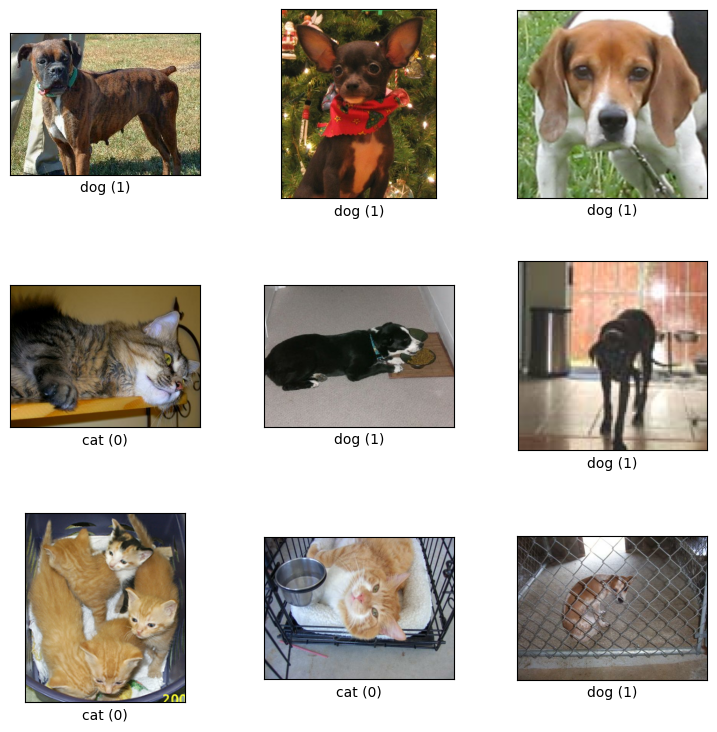

In [9]:
# 데이터셋 일부 시각화
fig = tfds.show_examples(ds_train, ds_info)

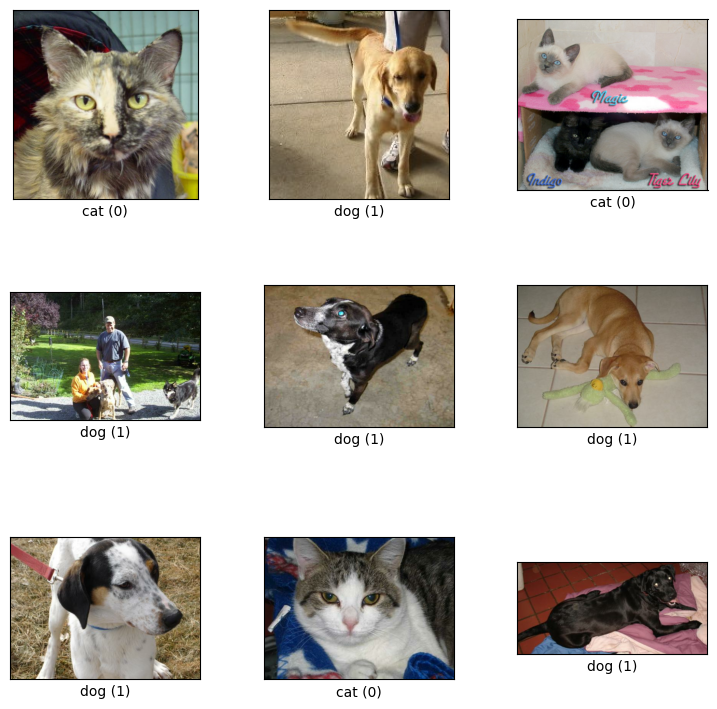

In [10]:
# 데이터셋 일부 시각화
fig = tfds.show_examples(ds_test, ds_info)

## 2. Model building

### building block 만들기

In [11]:
# function for building VGG Block

def build_resnet_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                    is_50=False
                   ):
    # 입력 레이어
    x = input_layer

    # conv 레이어
    if is_50 == False: # ResNet34
        # shortcut
        shortcut = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1)
        )(input_layer)

        # 디폴트 3개 CNN 레이어
        for cnn_num in range(num_cnn):
            x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    padding='same',
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_1'
                )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    padding='same',
                    kernel_initializer='he_normal',
                    name=f'block{block_num}_conv{cnn_num}_2'
                )(x)
            x = keras.layers.BatchNormalization()(x)

            # f(x) + x
            x = keras.layers.Add(name=f'block{block_num}_add_{cnn_num}')([shortcut, x])
            x = keras.layers.Activation("relu", name=f'block{block_num}_out_{cnn_num}')(x)


    else: #ResNet50
        #shortcut
        shortcut = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1)
            )(input_layer)

        # 디폴트 3개 CNN 레이어
        for cnn_num in range(num_cnn):

            # 1x1 CNN 레이어
            x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'block{block_num}_conv{cnn_num}_1x1'
                    )(x)

            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            # 3x3 CNN 레이어
            x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(3,3),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'block{block_num}_conv{cnn_num}_3x3'
                    )(x)

            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)


            # 1x1 CNN 레이어
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}_1x1_2'
            )(x)

            # 마지막 batch normalization
            x = keras.layers.BatchNormalization()(x)

            # f(x) + x
            x = keras.layers.Add(name=f'block{block_num}_add_{cnn_num}')([shortcut, x])
            x = keras.layers.Activation("relu", name=f'block{block_num}_out_{cnn_num}')(x)
    return x

In [12]:
# block 생성 테스트
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer)    # ResNet 블록 생성

In [13]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 block1_conv0_1 (Conv2D)     (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['block1_conv0_1[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['batch_normalization[0][0

### ResNet 모델 만들기

In [14]:
# NesNet 모델 자체를 생성하는 함수
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=num_classes,
              is_50=False):

    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
#     output = input_layer

    # 첫 번째 Conv 레이어
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2
    )(input_layer)

    # Max Pooling 레이어
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2
    )(x)

    # config list들의 길이만큼 반복해서 두 번째 - 다섯 번째 Conv 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50=is_50
        )

    output = keras.layers.GlobalAveragePooling2D(name="avg_pool")(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(1000, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(1, activation='sigmoid', name='predictions')(output)



    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [15]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 54, 54, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                               
                                                                                                  
 block0_conv0_1 (Conv2D)     (None, 54, 54, 64)           36928     ['max_pooling2d[0][0]'] 

In [16]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 109, 109, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 block0_conv0_1x1 (Conv2D)   (None, 54, 54, 64)           4160      ['max_pooling2d_1[0][0]'

In [17]:
BATCH_SIZE = 16
EPOCH = 10

In [18]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [19]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## 3. Model fitting

In [20]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", # 모델의 검증 정확도를 모니터링
                                  patience=2, # 두 번의 epoch동안 지표가 향상되지 않으면 훈련 중지
    )]

In [21]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    callbacks=callbacks_list,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 999s 828ms/step - loss: 0.6364 - accuracy: 0.6270 - val_loss: 1.4123 - val_accuracy: 0.5306
Epoch 2/10
 692/1163 [================>.............] - ETA: 5:58 - loss: 0.5638 - accuracy: 0.7072

KeyboardInterrupt: ignored

In [ ]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    callbacks=callbacks_list,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

## 4. Results

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'restnet50'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'restnet50'], loc='upper left')
plt.show()

## 5. Ablation Study (Model with skip connection vs. without skip connection)

# 회고
- `tensorflow_datasets`의 버전이 4.4.0인 경우 손상된 이미지가 있는걸로 추정. 이 경우 이를 4.9.3으로 업그레이드하거나 최선 버전이 있는 COLAB에서 진행하면 해결가능했다.
- 이미지 dataset의 size 맞추는 작업의 어려움을 느꼈다. tf.image.resize를 통해 사이즈 맞추는걸 배웠다.
- 원본 논문을 보고 아키텍처를 따라 코드로 구현하는 연습을 처음해봤는데, 쉽진 않아서 시간이 걸렸다. 다음번엔 더 잘할수 있을거란 자신감이 생겼다.
- 학습 속도의 여러 가지 변수가 있다는 걸 경험했다. 개발환경, GPU유무, 인터넷속도(?)
    - epoch 1개 당 약 15분 소요됐다.....
- layer name이 unique해야하는데 자꾸 중복되는 바람에 에러가 자주 떴다. 이를 유의해야한다.
- for문이 능사는 아니고 경우의 따라 line by line으로 layer를 쌓는게 훨씬 쉽다.